In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=2

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [4]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2260, dtype=torch.float64)

tensor(0.2174, dtype=torch.float64)

tensor(0.2219, dtype=torch.float64)

In [5]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [36]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=2
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr= config["lambda1"], config["lambda2"],config["lr"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.4)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=32)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_db9db_00000,TERMINATED,10.224.0.12:6231,0.05,0.001,0.6,1,11.5967,1.30887
train_model_db9db_00001,TERMINATED,10.224.0.12:6641,0.05,0.003,0.6,1,11.5163,1.13371
train_model_db9db_00002,TERMINATED,10.224.0.12:6644,0.05,0.003,0.6,1,11.9457,1.13371
train_model_db9db_00003,TERMINATED,10.224.0.12:6646,0.05,0.001,0.6,1,12.4326,1.30887
train_model_db9db_00004,TERMINATED,10.224.0.12:6648,0.03,0.003,0.6,1,12.1889,1.14426
train_model_db9db_00005,TERMINATED,10.224.0.12:6650,0.04,0.002,0.7,1,12.2576,1.20973
train_model_db9db_00006,TERMINATED,10.224.0.12:6652,0.05,0.002,0.6,1,12.0155,1.21742
train_model_db9db_00007,TERMINATED,10.224.0.12:6654,0.04,0.003,0.8,1,12.0842,1.07433
train_model_db9db_00008,TERMINATED,10.224.0.12:6655,0.04,0.001,0.6,1,11.5082,1.33212
train_model_db9db_00009,TERMINATED,10.224.0.12:6657,0.03,0.003,0.8,1,12.6986,1.04205


Result for train_model_db9db_00000:
  date: 2022-10-18_12-54-04
  done: false
  experiment_id: 6403460dc3324e40bd180cce8e4706c7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3088703393936156
  node_ip: 10.224.0.12
  pid: 6231
  time_since_restore: 11.596672773361206
  time_this_iter_s: 11.596672773361206
  time_total_s: 11.596672773361206
  timestamp: 1666068844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: db9db_00000
  warmup_time: 0.003746509552001953
  
Result for train_model_db9db_00000:
  date: 2022-10-18_12-54-04
  done: true
  experiment_id: 6403460dc3324e40bd180cce8e4706c7
  experiment_tag: 0_lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3088703393936156
  node_ip: 10.224.0.12
  pid: 6231
  time_since_restore: 11.596672773361206
  time_this_iter_s: 11.596672773361206
  time_total_s: 11.596672773361206
  timestamp: 1666068844
  timesteps_since_r

Result for train_model_db9db_00004:
  date: 2022-10-18_12-54-08
  done: false
  experiment_id: 5d92ae2491e644b8a3ddb4a2733b07c8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1442604064941406
  node_ip: 10.224.0.12
  pid: 6648
  time_since_restore: 12.188858985900879
  time_this_iter_s: 12.188858985900879
  time_total_s: 12.188858985900879
  timestamp: 1666068848
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: db9db_00004
  warmup_time: 0.006128787994384766
  
Result for train_model_db9db_00021:
  date: 2022-10-18_12-54-08
  done: false
  experiment_id: 65fa3e49992142ebae4a164fdaee5f58
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1425694942474365
  node_ip: 10.224.0.12
  pid: 6680
  time_since_restore: 11.651716947555542
  time_this_iter_s: 11.651716947555542
  time_total_s: 11.651716947555542
  timestamp: 1666068848
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: db9db_00021
 

Result for train_model_db9db_00024:
  date: 2022-10-18_12-54-09
  done: false
  experiment_id: 5bca15a1f1fb46f4bedfcfda2e77c962
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3133338928222655
  node_ip: 10.224.0.12
  pid: 6686
  time_since_restore: 11.941311597824097
  time_this_iter_s: 11.941311597824097
  time_total_s: 11.941311597824097
  timestamp: 1666068849
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: db9db_00024
  warmup_time: 0.0059125423431396484
  
Result for train_model_db9db_00024:
  date: 2022-10-18_12-54-09
  done: true
  experiment_id: 5bca15a1f1fb46f4bedfcfda2e77c962
  experiment_tag: 24_lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3133338928222655
  node_ip: 10.224.0.12
  pid: 6686
  time_since_restore: 11.941311597824097
  time_this_iter_s: 11.941311597824097
  time_total_s: 11.941311597824097
  timestamp: 1666068849
  timesteps_since

2022-10-18 12:54:09,814	INFO tune.py:758 -- Total run time: 19.36 seconds (19.19 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
db9db_00000          1.308870         11.596673  True            None   
db9db_00001          1.133713         11.516298  True            None   
db9db_00002          1.133713         11.945673  True            None   
db9db_00003          1.308870         12.432599  True            None   
db9db_00004          1.144260         12.188859  True            None   
db9db_00005          1.209732         12.257590  True            None   
db9db_00006          1.217416         12.015514  True            None   
db9db_00007          1.074329         12.084211  True            None   
db9db_00008          1.332124         11.508181  True            None   
db9db_00009          1.042049         12.698569  True            None   
db9db_00010          1.321581         12.547163  True            N

In [37]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.0420493364334107


{'lr': 0.8, 'lambda1': 0.03, 'lambda2': 0.003}

In [38]:
################## second step##################

prior=5
#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.4)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1564, grad_fn=<AddBackward0>)

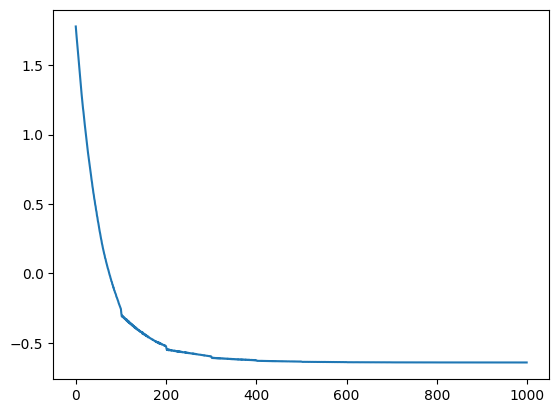

In [39]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [40]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.5694e+00, -9.2798e-01, -1.5377e+00, -1.6766e+00, -1.0656e+00,
         -5.8115e-01, -3.4357e-01, -2.8146e-01, -4.3524e-01,  5.9001e-01,
          1.3363e-05,  7.5603e-07,  1.1010e-05, -5.8998e-06,  1.8286e-05,
          9.7698e-07,  1.0606e-05, -2.4407e-05,  1.6337e-05, -1.4863e-06,
         -1.0241e-05,  2.1211e-05, -2.0210e-05,  1.8494e-05,  1.0327e-05,
          4.0381e-06,  7.4564e-06,  9.8561e-06,  1.0545e-05,  4.0953e-06,
         -3.5153e-06,  1.7789e-06,  2.3411e-05, -1.8445e-05,  3.3249e-06,
          5.2205e-06, -1.2910e-08,  2.9388e-06,  4.6603e-06,  1.7457e-05,
          2.1017e-05,  1.7349e-06,  4.3952e-06, -1.7988e-05,  1.4770e-02,
          8.5229e-06, -5.1695e-06, -1.3000e-05, -1.2265e-05,  1.6514e-05,
          3.5356e-06,  7.6468e-06, -1.0782e-05, -4.3311e-06, -4.2004e-06,
         -5.8739e-06,  1.8518e-05, -4.5813e-06, -4.3649e-06,  1.1408e-05,
         -1.0420e-05,  8.2003e-06, -1.4691e-01,  3.5421e-06,  3.0837e-06,
         -4.5040e-06, -2.7173e-06, -2.

tensor([[-1.5694e+00, -9.2798e-01, -1.5377e+00, -1.6766e+00, -1.0656e+00,
         -5.8115e-01, -3.4357e-01, -2.8146e-01, -4.3524e-01,  5.9001e-01,
          1.3363e-05,  7.5603e-07,  1.1010e-05, -5.8998e-06,  1.8286e-05,
          9.7698e-07,  1.0606e-05, -2.4407e-05,  1.6337e-05, -1.4863e-06,
         -1.0241e-05,  2.1211e-05, -2.0210e-05,  1.8494e-05,  1.0327e-05,
          4.0381e-06,  7.4564e-06,  9.8561e-06,  1.0545e-05,  4.0953e-06,
         -3.5153e-06,  1.7789e-06,  2.3411e-05, -1.8445e-05,  3.3249e-06,
          5.2205e-06, -1.2910e-08,  2.9388e-06,  4.6603e-06,  1.7457e-05,
          2.1017e-05,  1.7349e-06,  4.3952e-06, -1.7988e-05,  1.4770e-02,
          8.5229e-06, -5.1695e-06, -1.3000e-05, -1.2265e-05,  1.6514e-05,
          3.5356e-06,  7.6468e-06, -1.0782e-05, -4.3311e-06, -4.2004e-06,
         -5.8739e-06,  1.8518e-05, -4.5813e-06, -4.3649e-06,  1.1408e-05,
         -1.0420e-05,  8.2003e-06, -1.4691e-01,  3.5421e-06,  3.0837e-06,
         -4.5040e-06, -2.7173e-06, -2.

tensor([[-1.7598e+00, -1.1209e+00, -1.3956e+00, -1.8110e+00, -1.0972e+00,
         -6.6151e-01, -4.2834e-01, -3.9143e-01, -6.4336e-01,  7.3264e-01,
         -6.2944e-06, -1.1596e-06, -2.2410e-07,  1.0178e-05,  7.3968e-07,
         -8.4264e-08, -4.7528e-06,  1.7611e-06,  6.2274e-08,  7.4469e-07,
          1.2325e-06, -9.9285e-07,  2.0499e-06,  3.4211e-07,  5.6669e-06,
          1.3845e-06, -3.0975e-07, -8.3722e-06, -5.2842e-07, -1.4966e-07,
          6.9709e-07, -3.0390e-08, -5.0267e-08,  1.9254e-07, -1.2862e-06,
          7.6670e-08,  1.8059e-07,  1.7825e-07, -3.0683e-07, -2.6661e-09,
         -1.2647e-06,  6.2234e-07,  2.8983e-07,  6.9259e-07,  4.1772e-02,
         -1.0190e-05,  2.8653e-06, -1.4751e-07, -5.3051e-07,  5.0833e-08,
          1.1161e-07,  1.3718e-06, -4.8766e-07,  5.5428e-07,  6.0264e-08,
          1.7747e-06, -5.4598e-07, -6.2583e-07,  7.9976e-08, -3.1713e-08,
          4.1038e-06, -1.8453e-06, -5.5405e-01, -2.8596e-08,  9.4552e-07,
         -7.1614e-07, -4.0622e-07,  3.

In [41]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.1564)

tensor(0.0677)

tensor(0.0138)

tensor(0.0749)

In [42]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[89,  0],
       [ 1, 70]])

array([[86,  0],
       [ 0, 74]])

array([[72,  0],
       [ 1, 87]])

In [43]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.002]),
         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_f82c1_00000,TERMINATED,10.224.0.12:8013,0.1,0.03,0.002,0.7,1,15.9462,0.857387
train_model_f82c1_00001,TERMINATED,10.224.0.12:8371,0.4,0.05,0.002,0.7,1,14.7268,0.916513
train_model_f82c1_00002,TERMINATED,10.224.0.12:8373,0.2,0.03,0.002,0.6,1,14.3509,0.837817
train_model_f82c1_00003,TERMINATED,10.224.0.12:8375,0.9,0.04,0.002,0.6,1,14.4817,0.891441
train_model_f82c1_00004,TERMINATED,10.224.0.12:8377,0.8,0.04,0.002,0.8,1,14.7105,0.916064
train_model_f82c1_00005,TERMINATED,10.224.0.12:8379,0.9,0.03,0.002,0.6,1,15.2236,0.857101
train_model_f82c1_00006,TERMINATED,10.224.0.12:8381,0.4,0.04,0.002,0.8,1,14.3132,0.908898
train_model_f82c1_00007,TERMINATED,10.224.0.12:8383,0.7,0.05,0.002,0.8,1,14.2239,0.920879
train_model_f82c1_00008,TERMINATED,10.224.0.12:8385,0.1,0.05,0.002,0.8,1,14.4314,0.903132
train_model_f82c1_00009,TERMINATED,10.224.0.12:8387,0.9,0.05,0.002,0.6,1,15.4389,0.920543


Result for train_model_f82c1_00000:
  date: 2022-10-18_12-54-56
  done: false
  experiment_id: 0021a357a93d4a2a86420a75b84c5185
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8573870892576695
  node_ip: 10.224.0.12
  pid: 8013
  time_since_restore: 15.946187973022461
  time_this_iter_s: 15.946187973022461
  time_total_s: 15.946187973022461
  timestamp: 1666068896
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00000
  warmup_time: 0.0039386749267578125
  
Result for train_model_f82c1_00000:
  date: 2022-10-18_12-54-56
  done: true
  experiment_id: 0021a357a93d4a2a86420a75b84c5185
  experiment_tag: 0_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8573870892576695
  node_ip: 10.224.0.12
  pid: 8013
  time_since_restore: 15.946187973022461
  time_this_iter_s: 15.946187973022461
  time_total_s: 15.946187973022461
  timestamp: 1666068896
  timeste

Result for train_model_f82c1_00008:
  date: 2022-10-18_12-54-59
  done: true
  experiment_id: d99d1b465152465cbdcb4b655cf7dc4c
  experiment_tag: 8_eta=0.1000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.903131505255884
  node_ip: 10.224.0.12
  pid: 8385
  time_since_restore: 14.431373834609985
  time_this_iter_s: 14.431373834609985
  time_total_s: 14.431373834609985
  timestamp: 1666068899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00008
  warmup_time: 0.00465703010559082
  
Result for train_model_f82c1_00003:
  date: 2022-10-18_12-54-59
  done: false
  experiment_id: bf96bc7fb07e47ffba9ae37fa3c82a61
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8914409517299606
  node_ip: 10.224.0.12
  pid: 8375
  time_since_restore: 14.481695175170898
  time_this_iter_s: 14.481695175170898
  time_total_s: 14.481695175170898
  timestamp: 1666068899
  timesteps_

Result for train_model_f82c1_00020:
  date: 2022-10-18_12-54-59
  done: false
  experiment_id: 41c7d34a26804e4fad5e84c5fa97bdd4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9254520311479191
  node_ip: 10.224.0.12
  pid: 8409
  time_since_restore: 15.00296950340271
  time_this_iter_s: 15.00296950340271
  time_total_s: 15.00296950340271
  timestamp: 1666068899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00020
  warmup_time: 0.00441741943359375
  
Result for train_model_f82c1_00020:
  date: 2022-10-18_12-54-59
  done: true
  experiment_id: 41c7d34a26804e4fad5e84c5fa97bdd4
  experiment_tag: 20_eta=0.5000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9254520311479191
  node_ip: 10.224.0.12
  pid: 8409
  time_since_restore: 15.00296950340271
  time_this_iter_s: 15.00296950340271
  time_total_s: 15.00296950340271
  timestamp: 1666068899
  timesteps_sinc

Result for train_model_f82c1_00027:
  date: 2022-10-18_12-55-00
  done: false
  experiment_id: 445e5f01308049eeabbff6088f52be6c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9051126072907181
  node_ip: 10.224.0.12
  pid: 8424
  time_since_restore: 15.631453514099121
  time_this_iter_s: 15.631453514099121
  time_total_s: 15.631453514099121
  timestamp: 1666068900
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00027
  warmup_time: 0.004457712173461914
  
Result for train_model_f82c1_00027:
  date: 2022-10-18_12-55-00
  done: true
  experiment_id: 445e5f01308049eeabbff6088f52be6c
  experiment_tag: 27_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9051126072907181
  node_ip: 10.224.0.12
  pid: 8424
  time_since_restore: 15.631453514099121
  time_this_iter_s: 15.631453514099121
  time_total_s: 15.631453514099121
  timestamp: 1666068900
  timeste

Result for train_model_f82c1_00037:
  date: 2022-10-18_12-55-13
  done: false
  experiment_id: c266bf914f3449878e28e448934e6869
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8832276183165513
  node_ip: 10.224.0.12
  pid: 8383
  time_since_restore: 14.42345929145813
  time_this_iter_s: 14.42345929145813
  time_total_s: 14.42345929145813
  timestamp: 1666068913
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00037
  warmup_time: 0.006473541259765625
  
Result for train_model_f82c1_00037:
  date: 2022-10-18_12-55-13
  done: true
  experiment_id: c266bf914f3449878e28e448934e6869
  experiment_tag: 37_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8832276183165513
  node_ip: 10.224.0.12
  pid: 8383
  time_since_restore: 14.42345929145813
  time_this_iter_s: 14.42345929145813
  time_total_s: 14.42345929145813
  timestamp: 1666068913
  timesteps_sin

Result for train_model_f82c1_00051:
  date: 2022-10-18_12-55-14
  done: true
  experiment_id: 33e2d01a0a4547e5a1aa4da84e813b52
  experiment_tag: 51_eta=0.4000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8741905666693415
  node_ip: 10.224.0.12
  pid: 8407
  time_since_restore: 14.128063917160034
  time_this_iter_s: 14.128063917160034
  time_total_s: 14.128063917160034
  timestamp: 1666068914
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00051
  warmup_time: 0.005695343017578125
  
Result for train_model_f82c1_00050:
  date: 2022-10-18_12-55-14
  done: false
  experiment_id: 95d2f1a688294aa7834f2d677034717b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9229144723879583
  node_ip: 10.224.0.12
  pid: 8430
  time_since_restore: 14.236198663711548
  time_this_iter_s: 14.236198663711548
  time_total_s: 14.236198663711548
  timestamp: 1666068914
  timeste

Result for train_model_f82c1_00056:
  date: 2022-10-18_12-55-15
  done: false
  experiment_id: 8fe6987af2a8452a94f07bbc63f39711
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9030458256660914
  node_ip: 10.224.0.12
  pid: 8419
  time_since_restore: 14.694207668304443
  time_this_iter_s: 14.694207668304443
  time_total_s: 14.694207668304443
  timestamp: 1666068915
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00056
  warmup_time: 0.009903669357299805
  
Result for train_model_f82c1_00056:
  date: 2022-10-18_12-55-15
  done: true
  experiment_id: 8fe6987af2a8452a94f07bbc63f39711
  experiment_tag: 56_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9030458256660914
  node_ip: 10.224.0.12
  pid: 8419
  time_since_restore: 14.694207668304443
  time_this_iter_s: 14.694207668304443
  time_total_s: 14.694207668304443
  timestamp: 1666068915
  timeste

Result for train_model_f82c1_00063:
  date: 2022-10-18_12-55-18
  done: true
  experiment_id: bc9e18bf29d04c86be1d437b155db404
  experiment_tag: 63_eta=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8882845750019698
  node_ip: 10.224.0.12
  pid: 8403
  time_since_restore: 16.66940975189209
  time_this_iter_s: 16.66940975189209
  time_total_s: 16.66940975189209
  timestamp: 1666068918
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00063
  warmup_time: 0.004950284957885742
  
Result for train_model_f82c1_00064:
  date: 2022-10-18_12-55-26
  done: false
  experiment_id: 0021a357a93d4a2a86420a75b84c5185
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9228042268183302
  node_ip: 10.224.0.12
  pid: 8013
  time_since_restore: 15.216553926467896
  time_this_iter_s: 15.216553926467896
  time_total_s: 15.216553926467896
  timestamp: 1666068926
  timesteps_

Result for train_model_f82c1_00075:
  date: 2022-10-18_12-55-28
  done: false
  experiment_id: 003a7476546f4b8d896bc172a102e03a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8903888707356955
  node_ip: 10.224.0.12
  pid: 8428
  time_since_restore: 14.120320081710815
  time_this_iter_s: 14.120320081710815
  time_total_s: 14.120320081710815
  timestamp: 1666068928
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00075
  warmup_time: 0.005687236785888672
  
Result for train_model_f82c1_00075:
  date: 2022-10-18_12-55-28
  done: true
  experiment_id: 003a7476546f4b8d896bc172a102e03a
  experiment_tag: 75_eta=0.8000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8903888707356955
  node_ip: 10.224.0.12
  pid: 8428
  time_since_restore: 14.120320081710815
  time_this_iter_s: 14.120320081710815
  time_total_s: 14.120320081710815
  timestamp: 1666068928
  timeste

Result for train_model_f82c1_00082:
  date: 2022-10-18_12-55-29
  done: false
  experiment_id: a7fbb639c2004b579465900d23e0af6e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8859148788012009
  node_ip: 10.224.0.12
  pid: 8399
  time_since_restore: 14.504945993423462
  time_this_iter_s: 14.504945993423462
  time_total_s: 14.504945993423462
  timestamp: 1666068929
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00082
  warmup_time: 0.004950761795043945
  
Result for train_model_f82c1_00078:
  date: 2022-10-18_12-55-28
  done: true
  experiment_id: d6f3b47a1efa45d4bd42d76ddd88748b
  experiment_tag: 78_eta=0.9000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8914409517299606
  node_ip: 10.224.0.12
  pid: 8401
  time_since_restore: 14.73684024810791
  time_this_iter_s: 14.73684024810791
  time_total_s: 14.73684024810791
  timestamp: 1666068928
  timesteps_

Result for train_model_f82c1_00085:
  date: 2022-10-18_12-55-30
  done: false
  experiment_id: 41c7d34a26804e4fad5e84c5fa97bdd4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9186285299876931
  node_ip: 10.224.0.12
  pid: 8409
  time_since_restore: 15.038038969039917
  time_this_iter_s: 15.038038969039917
  time_total_s: 15.038038969039917
  timestamp: 1666068930
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00085
  warmup_time: 0.00441741943359375
  
Result for train_model_f82c1_00085:
  date: 2022-10-18_12-55-30
  done: true
  experiment_id: 41c7d34a26804e4fad5e84c5fa97bdd4
  experiment_tag: 85_eta=0.8000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9186285299876931
  node_ip: 10.224.0.12
  pid: 8409
  time_since_restore: 15.038038969039917
  time_this_iter_s: 15.038038969039917
  time_total_s: 15.038038969039917
  timestamp: 1666068930
  timestep

Result for train_model_f82c1_00093:
  date: 2022-10-18_12-55-33
  done: false
  experiment_id: 445e5f01308049eeabbff6088f52be6c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8859148788012009
  node_ip: 10.224.0.12
  pid: 8424
  time_since_restore: 16.089683771133423
  time_this_iter_s: 16.089683771133423
  time_total_s: 16.089683771133423
  timestamp: 1666068933
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00093
  warmup_time: 0.004457712173461914
  
Result for train_model_f82c1_00093:
  date: 2022-10-18_12-55-33
  done: true
  experiment_id: 445e5f01308049eeabbff6088f52be6c
  experiment_tag: 93_eta=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8859148788012009
  node_ip: 10.224.0.12
  pid: 8424
  time_since_restore: 16.089683771133423
  time_this_iter_s: 16.089683771133423
  time_total_s: 16.089683771133423
  timestamp: 1666068933
  timeste

Result for train_model_f82c1_00100:
  date: 2022-10-18_12-55-42
  done: true
  experiment_id: 744bd63d53e14b8eb1278b47cdbe0477
  experiment_tag: 100_eta=0.2000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8645373767310647
  node_ip: 10.224.0.12
  pid: 8377
  time_since_restore: 14.303755044937134
  time_this_iter_s: 14.303755044937134
  time_total_s: 14.303755044937134
  timestamp: 1666068942
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00100
  warmup_time: 0.005910634994506836
  
Result for train_model_f82c1_00104:
  date: 2022-10-18_12-55-42
  done: false
  experiment_id: 33e2d01a0a4547e5a1aa4da84e813b52
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8516907070344015
  node_ip: 10.224.0.12
  pid: 8407
  time_since_restore: 13.998355865478516
  time_this_iter_s: 13.998355865478516
  time_total_s: 13.998355865478516
  timestamp: 1666068942
  timest

Result for train_model_f82c1_00111:
  date: 2022-10-18_12-55-43
  done: false
  experiment_id: a7fbb639c2004b579465900d23e0af6e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8764528951669099
  node_ip: 10.224.0.12
  pid: 8399
  time_since_restore: 14.471105575561523
  time_this_iter_s: 14.471105575561523
  time_total_s: 14.471105575561523
  timestamp: 1666068943
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00111
  warmup_time: 0.004950761795043945
  
Result for train_model_f82c1_00111:
  date: 2022-10-18_12-55-43
  done: true
  experiment_id: a7fbb639c2004b579465900d23e0af6e
  experiment_tag: 111_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8764528951669099
  node_ip: 10.224.0.12
  pid: 8399
  time_since_restore: 14.471105575561523
  time_this_iter_s: 14.471105575561523
  time_total_s: 14.471105575561523
  timestamp: 1666068943
  timest

Result for train_model_f82c1_00120:
  date: 2022-10-18_12-55-45
  done: false
  experiment_id: bf96bc7fb07e47ffba9ae37fa3c82a61
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9231411660525983
  node_ip: 10.224.0.12
  pid: 8375
  time_since_restore: 14.75428056716919
  time_this_iter_s: 14.75428056716919
  time_total_s: 14.75428056716919
  timestamp: 1666068945
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00120
  warmup_time: 0.006693840026855469
  
Result for train_model_f82c1_00120:
  date: 2022-10-18_12-55-45
  done: true
  experiment_id: bf96bc7fb07e47ffba9ae37fa3c82a61
  experiment_tag: 120_eta=0.9000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9231411660525983
  node_ip: 10.224.0.12
  pid: 8375
  time_since_restore: 14.75428056716919
  time_this_iter_s: 14.75428056716919
  time_total_s: 14.75428056716919
  timestamp: 1666068945
  timesteps_si

Result for train_model_f82c1_00123:
  date: 2022-10-18_12-55-47
  done: false
  experiment_id: f614739442dc49ed859ac83281f89f4f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8731345463630131
  node_ip: 10.224.0.12
  pid: 8397
  time_since_restore: 15.725077390670776
  time_this_iter_s: 15.725077390670776
  time_total_s: 15.725077390670776
  timestamp: 1666068947
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00123
  warmup_time: 0.009041070938110352
  
Result for train_model_f82c1_00123:
  date: 2022-10-18_12-55-47
  done: true
  experiment_id: f614739442dc49ed859ac83281f89f4f
  experiment_tag: 123_eta=0.1000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8731345463630131
  node_ip: 10.224.0.12
  pid: 8397
  time_since_restore: 15.725077390670776
  time_this_iter_s: 15.725077390670776
  time_total_s: 15.725077390670776
  timestamp: 1666068947
  timest

Result for train_model_f82c1_00138:
  date: 2022-10-18_12-55-56
  done: false
  experiment_id: 164fae4c0c4d4a6eb0c8b23b8b2d60a5
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9251761678844902
  node_ip: 10.224.0.12
  pid: 8389
  time_since_restore: 13.744090795516968
  time_this_iter_s: 13.744090795516968
  time_total_s: 13.744090795516968
  timestamp: 1666068956
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00138
  warmup_time: 0.005741596221923828
  
Result for train_model_f82c1_00138:
  date: 2022-10-18_12-55-56
  done: true
  experiment_id: 164fae4c0c4d4a6eb0c8b23b8b2d60a5
  experiment_tag: 138_eta=0.4000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9251761678844902
  node_ip: 10.224.0.12
  pid: 8389
  time_since_restore: 13.744090795516968
  time_this_iter_s: 13.744090795516968
  time_total_s: 13.744090795516968
  timestamp: 1666068956
  timest

Result for train_model_f82c1_00141:
  date: 2022-10-18_12-55-58
  done: false
  experiment_id: a7fbb639c2004b579465900d23e0af6e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9143342019999977
  node_ip: 10.224.0.12
  pid: 8399
  time_since_restore: 14.789347410202026
  time_this_iter_s: 14.789347410202026
  time_total_s: 14.789347410202026
  timestamp: 1666068958
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00141
  warmup_time: 0.004950761795043945
  
Result for train_model_f82c1_00141:
  date: 2022-10-18_12-55-58
  done: true
  experiment_id: a7fbb639c2004b579465900d23e0af6e
  experiment_tag: 141_eta=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9143342019999977
  node_ip: 10.224.0.12
  pid: 8399
  time_since_restore: 14.789347410202026
  time_this_iter_s: 14.789347410202026
  time_total_s: 14.789347410202026
  timestamp: 1666068958
  timest

Result for train_model_f82c1_00154:
  date: 2022-10-18_12-55-59
  done: true
  experiment_id: 41c7d34a26804e4fad5e84c5fa97bdd4
  experiment_tag: 154_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8571009826077564
  node_ip: 10.224.0.12
  pid: 8409
  time_since_restore: 13.222718715667725
  time_this_iter_s: 13.222718715667725
  time_total_s: 13.222718715667725
  timestamp: 1666068959
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00154
  warmup_time: 0.00441741943359375
  
Result for train_model_f82c1_00149:
  date: 2022-10-18_12-55-59
  done: false
  experiment_id: bf96bc7fb07e47ffba9ae37fa3c82a61
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9254520311479191
  node_ip: 10.224.0.12
  pid: 8375
  time_since_restore: 14.349931001663208
  time_this_iter_s: 14.349931001663208
  time_total_s: 14.349931001663208
  timestamp: 1666068959
  timeste

Result for train_model_f82c1_00157:
  date: 2022-10-18_12-56-00
  done: false
  experiment_id: f614739442dc49ed859ac83281f89f4f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9030458256660914
  node_ip: 10.224.0.12
  pid: 8397
  time_since_restore: 13.154407739639282
  time_this_iter_s: 13.154407739639282
  time_total_s: 13.154407739639282
  timestamp: 1666068960
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f82c1_00157
  warmup_time: 0.009041070938110352
  
Result for train_model_f82c1_00157:
  date: 2022-10-18_12-56-00
  done: true
  experiment_id: f614739442dc49ed859ac83281f89f4f
  experiment_tag: 157_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9030458256660914
  node_ip: 10.224.0.12
  pid: 8397
  time_since_restore: 13.154407739639282
  time_this_iter_s: 13.154407739639282
  time_total_s: 13.154407739639282
  timestamp: 1666068960
  timest

2022-10-18 12:56:01,142	INFO tune.py:758 -- Total run time: 82.78 seconds (82.59 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
f82c1_00000         0.857387         15.946188  True            None   
f82c1_00001         0.916513         14.726758  True            None   
f82c1_00002         0.837817         14.350869  True            None   
f82c1_00003         0.891441         14.481695  True            None   
f82c1_00004         0.916064         14.710474  True            None   
...                      ...               ...   ...             ...   
f82c1_00155         0.925452         13.119801  True            None   
f82c1_00156         0.865050         12.803789  True            None   
f82c1_00157         0.903046         13.154408  True            None   
f82c1_00158         0.871628         12.394085  True            None   
f82c1_00159         0.856825         12.138396  True            None   

     

In [44]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.9255938841494986


{'lambda1': 0.05, 'lambda2': 0.002, 'eta': 0.4, 'lr': 0.6}

In [45]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3333, grad_fn=<AddBackward0>)

tensor(0.1210, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0102, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1382, grad_fn=<BinaryCrossEntropyBackward0>)

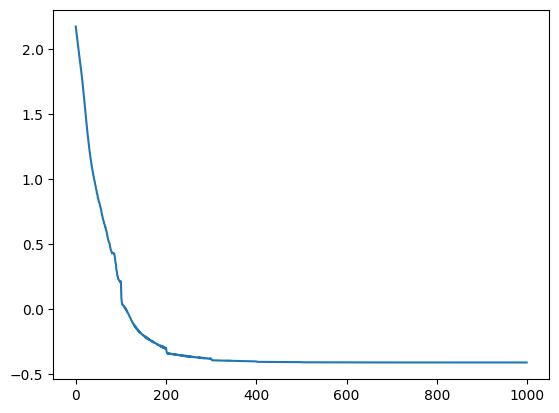

In [46]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [47]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-9.3524e-02, -9.4061e-02, -2.4974e-01, -1.0793e-01, -2.0729e-01,
         -2.2835e-01, -1.5159e-01, -1.1614e-01, -2.0577e-01, -2.5366e-01,
         -2.0208e-06, -2.3223e-07, -1.9235e-06, -1.9489e-03,  6.1536e-07,
          2.3335e-06, -1.1412e-06, -3.3869e-06, -3.8168e-07, -1.8366e-06,
          2.5093e-06, -2.3799e-06, -7.8055e-07,  1.6071e-06,  9.9583e-07,
         -2.4339e-07, -2.3347e-06, -1.2997e-06, -2.2799e-06,  4.0125e-07,
         -2.6039e-06,  3.2863e-08, -1.4469e-08,  2.0139e-06,  1.4652e-06,
         -1.3338e-06,  2.4620e-06,  2.1091e-07,  1.0236e-06, -2.2310e-06,
         -1.8385e-06,  1.2983e-06,  1.2971e-06,  1.8184e-07, -2.1516e-06,
         -7.0480e-04, -6.7682e-07, -2.2832e-06,  1.2373e-06, -2.0779e-06,
         -6.6834e-08,  1.8303e-06, -6.0365e-07, -5.6475e-08, -1.3801e-06,
         -9.9147e-07, -9.7751e-07, -3.3607e-07,  2.3892e-06, -1.8118e-06,
         -2.2035e-06, -6.9711e-07,  1.0545e-06,  1.1251e-06,  1.6166e-06,
         -4.2849e-07,  2.3564e-06, -2.

tensor([[-9.3524e-02, -9.4061e-02, -2.4974e-01, -1.0793e-01, -2.0729e-01,
         -2.2835e-01, -1.5159e-01, -1.1614e-01, -2.0577e-01, -2.5366e-01,
         -2.0208e-06, -2.3223e-07, -1.9235e-06, -1.9489e-03,  6.1536e-07,
          2.3335e-06, -1.1412e-06, -3.3869e-06, -3.8168e-07, -1.8366e-06,
          2.5093e-06, -2.3799e-06, -7.8055e-07,  1.6071e-06,  9.9583e-07,
         -2.4339e-07, -2.3347e-06, -1.2997e-06, -2.2799e-06,  4.0125e-07,
         -2.6039e-06,  3.2863e-08, -1.4469e-08,  2.0139e-06,  1.4652e-06,
         -1.3338e-06,  2.4620e-06,  2.1091e-07,  1.0236e-06, -2.2310e-06,
         -1.8385e-06,  1.2983e-06,  1.2971e-06,  1.8184e-07, -2.1516e-06,
         -7.0480e-04, -6.7682e-07, -2.2832e-06,  1.2373e-06, -2.0779e-06,
         -6.6834e-08,  1.8303e-06, -6.0365e-07, -5.6475e-08, -1.3801e-06,
         -9.9147e-07, -9.7751e-07, -3.3607e-07,  2.3892e-06, -1.8118e-06,
         -2.2035e-06, -6.9711e-07,  1.0545e-06,  1.1251e-06,  1.6166e-06,
         -4.2849e-07,  2.3564e-06, -2.

tensor([[-1.4527e-01, -2.2575e-01, -2.6924e-01, -1.7665e-01,  2.5990e-01,
         -2.3779e-01, -1.8475e-01, -1.4409e-01, -2.4742e-01, -3.2515e-01,
          1.8386e-08,  7.7985e-09,  2.6252e-08,  1.7211e-02, -3.4883e-08,
         -1.3067e-07, -6.9521e-07,  6.1721e-07, -2.0305e-07, -6.7789e-07,
          3.1965e-07, -1.2477e-07, -7.4748e-08, -4.3039e-07,  1.3725e-06,
          6.1117e-09, -8.0663e-07, -9.2426e-07,  3.9409e-08,  2.4166e-08,
         -1.4318e-08,  2.8916e-09,  4.4673e-08,  2.9787e-07,  2.9404e-07,
          2.3090e-08, -8.7498e-08,  3.3512e-07,  1.4684e-06, -4.2596e-08,
         -1.8201e-07, -5.1394e-08,  3.4811e-08, -3.6511e-08, -1.6666e-07,
         -2.4907e-02, -7.1918e-08,  1.1479e-07,  5.8558e-08,  2.7180e-09,
         -2.8359e-08,  2.0468e-07, -1.1546e-07,  3.0626e-07,  2.3750e-07,
          3.8878e-07,  1.2327e-07,  2.8317e-07, -5.1956e-08,  1.5470e-06,
          3.1372e-07,  1.2139e-07, -1.4851e-07, -1.7356e-07,  6.6411e-08,
         -1.1479e-07,  1.0585e-07, -1.

In [48]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.6525e-01, 9.7662e-01, 8.7696e-01, 1.1286e-01, 2.5429e-04, 9.5652e-01,
        9.4007e-01, 4.7854e-01, 9.2606e-01, 2.2674e-01, 3.7271e-05, 5.5137e-01,
        9.7938e-01, 5.2079e-03, 6.1164e-01, 9.7236e-01, 2.3539e-01, 9.6588e-01,
        1.0722e-02, 1.0383e-02, 1.0536e-02, 8.0385e-01, 8.7251e-01, 7.6571e-02,
        6.7961e-01, 1.4848e-01, 4.0596e-01, 1.4405e-02, 6.1026e-01, 9.2584e-01,
        5.0668e-01, 1.2776e-01, 3.1628e-01, 6.6311e-01, 2.6837e-02, 9.2853e-01,
        9.1750e-01, 5.0326e-01, 7.1895e-01, 3.9968e-04],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 0.])

tensor([3.0844e-02, 9.9963e-01, 8.6427e-01, 1.4637e-01, 9.9341e-01, 9.9719e-01,
        9.5297e-01, 9.9804e-01, 7.4683e-01, 5.0340e-04, 3.3645e-01, 9.5472e-01,
        1.7791e-04, 9.9891e-01, 9.8370e-01, 1.8711e-01, 9.6978e-01, 9.8132e-01,
        1.0200e-01, 9.9478e-01, 9.1508e-01, 5.6168e-01, 1.9873e-02, 3.8142e-03,
        9.4710e-01, 6.7326e-04, 8.3195e-01, 2.2942e-02, 2.2646e-02, 5.2715e-01,
        9.5787e-01, 9.8861e-01, 9.1903e-01, 8.9413e-01, 9.9779e-01, 9.9778e-01,
        9.9785e-01, 3.3563e-01, 9.9663e-01, 9.8112e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1.])

tensor([1.4127e-01, 9.8429e-01, 9.8089e-01, 9.4535e-01, 6.5226e-02, 2.5831e-01,
        8.9843e-02, 3.6249e-01, 9.7435e-01, 3.6826e-01, 9.5840e-01, 4.2753e-04,
        9.8652e-01, 9.1371e-02, 9.8002e-01, 6.2299e-02, 9.8414e-01, 9.4840e-01,
        9.7865e-01, 9.8148e-01, 2.4595e-01, 1.6995e-02, 9.0963e-01, 7.3729e-02,
        1.7846e-01, 4.1712e-04, 1.3626e-02, 9.7849e-01, 8.8214e-01, 9.7718e-01,
        7.1109e-01, 1.3232e-03, 6.9114e-01, 8.6350e-01, 4.3868e-02, 1.1545e-01,
        5.7165e-01, 1.0681e-01, 4.3476e-01, 1.0714e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 0., 0., 0.])

In [49]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[47,  5],
       [ 5, 63]])

0.9264705882352942

0.9038461538461539

0.9166666666666666

0.9264705882352942

0.9264705882352942

In [50]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[15,  1],
       [ 3, 21]])

0.875

0.9375

array([[12,  4],
       [ 1, 23]])

0.9583333333333334

0.75

array([[20,  0],
       [ 1, 19]])

0.95

1.0

In [51]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-9.35243368e-02, -9.40611735e-02, -2.49741212e-01,
        -1.07932799e-01, -2.07285926e-01, -2.28351250e-01,
        -1.51592404e-01, -1.16141379e-01, -2.05769047e-01,
        -2.53662586e-01, -2.02081492e-06, -2.32228714e-07,
        -1.92351240e-06, -1.94890157e-03,  6.15357521e-07,
         2.33345986e-06, -1.14116983e-06, -3.38691234e-06,
        -3.81684629e-07, -1.83659165e-06,  2.50925564e-06,
        -2.37989798e-06, -7.80552625e-07,  1.60714330e-06,
         9.95828373e-07, -2.43393629e-07, -2.33473929e-06,
        -1.29973000e-06, -2.27989403e-06,  4.01254084e-07,
        -2.60387924e-06,  3.28631806e-08, -1.44690375e-08,
         2.01387434e-06,  1.46519278e-06, -1.33384196e-06,
         2.46202012e-06,  2.10907643e-07,  1.02359775e-06,
        -2.23101006e-06, -1.83848329e-06,  1.29828049e-06,
         1.29709770e-06,  1.81840662e-07, -2.15164459e-06,
        -7.04801059e-04, -6.76823618e-07, -2.28319414e-06,
         1.23727079e-06, -2.07786547e-06, -6.68339482e-0

array([[-9.35243368e-02, -9.40611735e-02, -2.49741212e-01,
        -1.07932799e-01, -2.07285926e-01, -2.28351250e-01,
        -1.51592404e-01, -1.16141379e-01, -2.05769047e-01,
        -2.53662586e-01, -2.02081492e-06, -2.32228714e-07,
        -1.92351240e-06, -1.94890157e-03,  6.15357521e-07,
         2.33345986e-06, -1.14116983e-06, -3.38691234e-06,
        -3.81684629e-07, -1.83659165e-06,  2.50925564e-06,
        -2.37989798e-06, -7.80552625e-07,  1.60714330e-06,
         9.95828373e-07, -2.43393629e-07, -2.33473929e-06,
        -1.29973000e-06, -2.27989403e-06,  4.01254084e-07,
        -2.60387924e-06,  3.28631806e-08, -1.44690375e-08,
         2.01387434e-06,  1.46519278e-06, -1.33384196e-06,
         2.46202012e-06,  2.10907643e-07,  1.02359775e-06,
        -2.23101006e-06, -1.83848329e-06,  1.29828049e-06,
         1.29709770e-06,  1.81840662e-07, -2.15164459e-06,
        -7.04801059e-04, -6.76823618e-07, -2.28319414e-06,
         1.23727079e-06, -2.07786547e-06, -6.68339482e-0

array([[-1.45271897e-01, -2.25752503e-01, -2.69242764e-01,
        -1.76653937e-01,  2.59895355e-01, -2.37794220e-01,
        -1.84752047e-01, -1.44093975e-01, -2.47419387e-01,
        -3.25149357e-01,  1.83857978e-08,  7.79852982e-09,
         2.62521969e-08,  1.72112007e-02, -3.48825004e-08,
        -1.30673357e-07, -6.95211668e-07,  6.17214596e-07,
        -2.03048472e-07, -6.77887954e-07,  3.19650724e-07,
        -1.24768761e-07, -7.47479945e-08, -4.30394039e-07,
         1.37247150e-06,  6.11169693e-09, -8.06630794e-07,
        -9.24257108e-07,  3.94086506e-08,  2.41660363e-08,
        -1.43180570e-08,  2.89159052e-09,  4.46728023e-08,
         2.97871338e-07,  2.94036511e-07,  2.30903172e-08,
        -8.74977744e-08,  3.35122706e-07,  1.46836760e-06,
        -4.25957367e-08, -1.82009359e-07, -5.13944123e-08,
         3.48108138e-08, -3.65106558e-08, -1.66657017e-07,
        -2.49071009e-02, -7.19181230e-08,  1.14788321e-07,
         5.85577915e-08,  2.71795852e-09, -2.83586843e-0

In [52]:
threshold=0.1
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.09352434, -0.09406117, -0.24974121, -0.1079328 , -0.20728593,
        -0.22835125, -0.1515924 , -0.11614138, -0.20576905, -0.2536626 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10